Theoretical Background for Section 1 & 2:
[Further Reading](https://github.com/nicolasthill/Qiskit-Hackathon-at-World-of-QUANTUM/blob/main/QAOA%20101/QAOA_Theoretical_Background.ipynb) contains supplemental material that provides an in-depth explanation of the material below.


## 1. Optimization
* Optimize y while controlling x
    * Find a function f which generates a solution; y = f(x)
* Cost function: the loss that we are trying to minimize
* Cost function in quantum mechanics
    * The system occupies the state of least energy
    * Likelihood of finding a local minimum is lower due to quantum annealing
    * @TODO **ADD IMAGE HERE for COST FUNC** @Peter

## 2. QAOA: Quantum Approximate Optimization Algorithm
* QAOA

    * gives an approximately optimal solution using quantum methods
    * designed to solve combinatorial optimization problems
    * constraint: only linear and quadratic terms are allowed for the cost function

* Hamiltonian: something that governs the behaviour of any quantum system

    * Defines the energies that our system can be in
    * QAOA finds the ground state (state which corresponds to lowest energy level) of a given Hamiltonian
    * We can translate any cost function into a Hamiltonian
    * Minimizing the cost function is equivalent to finding the ground state of the Hamiltonian

* Adiabatic theorem: if we have a system in its ground state and we transform this system slowly enough, it will remain in its lowest energy state
* Constructing a time evolution operator for transformation

    * Not trivial because the problem and mixer Hamiltonian don’t compute
    * Use trotterizaton formula
    * At each step mixer and problem Hamiltonian exponents are supplied with a parameter beta and gamma respectively
        * These parameters play a key role because they simulate the adiabatic process
    * Naturally one would expect betas to decrease and gammas to increase
        * This reflects the fact that weight of the problem Hamiltonian should increase and the weight of mixer decrease
* Exponentiating the mixer Hamiltonian

    * Applying a rotational X gate to each qubit at an angle 2 beta
    * Applying a number of rotational Z gates and controlled rotational Z gates to all the qubits
    * Rotations also depend on the coefficients from QUBO matrix
  
* QAOA algorithm
    * At each optimization step, measure the state of the parameterized circuit
        * Measurement results in a distribution of probabilities
    * To evaluate cost, scale the energy for each bitstring that we measured with its probability and take the average
    * Classical optimizer now tries to minimize this energy by updating parameter of the circuit
    * Measure quantum state after updating parameters
    * Continue until optimizer lands in an optimal solution


## Implementation

We'll now start the daunting task of actually implementing the QAOA algorithm in order to understand how it is able to harness quantum effects to speed up the optimization process.

### 1. MaxCut Problem

We will do this by solving a problem from graph theory: the max-cut Problem.

The objective of max-cut is to split the set of vertices of a graph into two subsets, such that the sum of the weights of the edges having one endpoint in each of the subsets is maximum. This, of course, sounds like gibberish to anyone unfamiliar with graph theory but we illustrate this with a scenario every student here is familiar with: passing paper messages in a classroom.

Now, the nodes of the graph represent the students and the weights of the edges represent the number of notes passed between a pair of students.

Take the following as an example situation:

- We have the four students: Anna, Bob, Clara and Diego
- Teacher wants to limit communication among students, and through investigation knows exactly how many notes are passed between each pair of students for one class
- Connection between a single pair of nodes -> results in note-passing
- Class is moving to a new room, with a huge gap in the middle that prevents note-passing to the other side
- How should the teacher divide the class into two groups to **minimize** notes sent? (Optimization Task)

Result of QAOA solution: total communication reduced from 4 to 0

Moving onto implementation:

Formalizing this graph

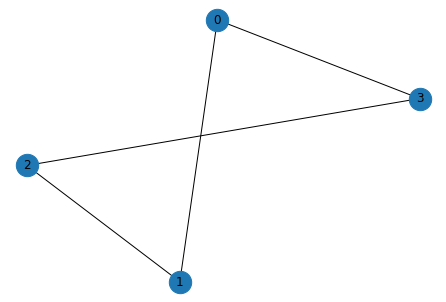

In [3]:
import networkx as nx               # package for graphs
import numpy as np                  # package for basic math
import matplotlib.pyplot as plt     # package for plotting
from IPython.display import Image   # package for images

# import qiskit function
from qiskit import IBMQ, Aer, execute               # functions used to run and simulate the quantum circuit
from qiskit import QuantumCircuit                   # class that runs the circuits
from qiskit.circuit import ParameterVector          # class for parameter storage
from qiskit.optimization import QuadraticProgram    # allows encoding the graph
from qiskit.visualization import plot_histogram     # for plotting results

# Let's define the problem in the form of a graph

graph = nx.Graph()  # create the graph


graph.add_nodes_from([0, 1, 2, 3])                          # list of 4 students added to the graph as nodes
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])      # student pairs (0,2) and (1,3) don't communicate, the rest do
nx.draw(graph, with_labels=True, alpha=1, node_size=500)    # we draw the graph

We need to encode the problem further into a form that the QAOA can use -> QuadraticProgram.

Now, translating a weighted graph into a QUBO is very straightforward and can be implemented in the following way, where W is the weight matrix of our graph.

In [4]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    '''Generates a QuadraticProblem from a graph.
    Args:
        graph: graph of the problem of class nx.Graph
    Returns: 
        quadratic problem of class QuadraticProgram
    '''
    
    weight_matrix = nx.adjacency_matrix(graph)  # generate weight_matrix from the graph
    shape = weight_matrix.shape                 # to determine number of nodes from weight_matrix
    size = shape[0]                             # number of nodes
    
    ## build QUBO matrix Q from weight matrix

    qubo_matrix = np.zeros((size, size))    # initialize qubo marix shape
    qubo_vector = np.zeros(size)
    
    
    for i in range(size):                   # populate matrix and vector
        for j in range(size):
            qubo_matrix[i,j] -= weight_matrix[i, j]
            qubo_vector[i] += weight_matrix[i,j]
            
    ## define the quadratic program

    quadratic_program = QuadraticProgram('maxcut')      # initialize program for maxcut problem
    
    
    for i in range(size):                               # name the nodes x_1 to x_n
        var_name = 'x_{}'.format(i)
        quadratic_program.binary_var(var_name)
    
    quadratic_program.maximize(quadratic=qubo_matrix,   # generate the quadratic_program from the qubo matrix and vector
                                linear=qubo_vector,
                                constant=0)   
    
    return quadratic_program

For this toy problem we have already seen our parametrized circuit. We see that for any pair of connected edges there is RZZ (controlled rotational Z) gate. And for non-connected edges the RZZ gates actually have 0 as a parameter, so it doesn’t do anything.

In [5]:
def qaoa_circuit(qubo: QuadraticProgram, gammas, betas, p: int = 1):
    '''
    Given a QUBO instance and the number of layers, construct 
    a corresponding parametrized circuit with p layers.
    Args:
        qubo: The QuadraticProgram qubo instance
        p: The number of layers in the QAOA circuit
    Returns: 
        The parametrized QAOA circuit
    '''

    size = len(qubo.variables)                                          # number of nodes
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)     # get qubo matrix
    qubo_linearity = qubo.objective.linear.to_array()                   # get qubo vector

    ## Generate the circuit
    
    qaoa_circuit = QuantumCircuit(size, size)   # Prepare the quantum and classical registers with n_qubits = n_nodes

    qaoa_circuit.h(range(size))                 # Apply the initial layer of Hadamard gates to all qubits

    
    for layer in range(p):  # each iteration creates a depth layer

        # Apply Rz rotational gates from the cost layer
        for i in range(size):
            w_i = (qubo_linearity[layer] + sum(qubo_matrix[i])) / 2
            qaoa_circuit.rz(phi=gammas[layer]*w_i, qubit=i)

        # Apply the Rzz rotational gates for entangled qubits from cost layer
        for i in range(1,size):
            for j in range(i):
                w_ij = qubo_matrix[i,j]/4
                qaoa_circuit.rzz(theta=gammas[layer]*w_ij, qubit1=i, qubit2=j)
                
        # Apply single qubit Rx rotations from mixer layer to all qubits
        qaoa_circuit.barrier()
        for i in range(size):
            qaoa_circuit.rx(theta=2*betas[layer], qubit=i)

    # Measure the result in computational basis
    qaoa_circuit.barrier()
    qaoa_circuit.measure(range(size), range(size))

    return qaoa_circuit

Computing energy for a single bitstring is trivial.
We can just plug it in our QUBO problem.

For a distribution of measured bitstrings we need to scale the energy with the probability of measuring this bitstring.

In [6]:
def compute_energy(qubo: QuadraticProgram, x: str):
    """
    Given a bitstring as a solution, returns
    the corresponding energy according to given QUBO.
    Args:
        qubo: The quadratic qubo instance
        x: Solution bitstring      
    Returns:
        e: Energy
    """

    n = len(x)                              # number of nodes
    v =  np.fromstring(x,'u1') - ord('0')   

    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)     # get qubo matrix
    qubo_linearity = qubo.objective.linear.to_array()                   # get qubo vector

    e = 0   # energy start at zero

    for i in range(n):
        for j in range(n):
            e += qubo_matrix[i][j]*v[i]*v[j]
    
    for i in range(n):
        e += qubo_linearity[i]*v[i]
        
    return e

In [7]:
def compute_expectation(qubo: QuadraticProgram, counts):
    """
    Computes expectation value based on measurement results
    Args:
        counts: dict
                Key as bitstring, val as count
           
        qubo: The quadratic qubo instance
    Returns:
        avg: Expectation value
    """
    sum = 0         # initialize as zero
    sum_count = 0   # initialize as zero

    for bitstring, count in counts.items():     # iterate over all results
        
        obj = compute_energy(qubo, bitstring)   # determine energy of result
        sum += obj * count                      # add resulting energy times number of times it appeared
        sum_count += count                      # update total count
        
    return sum/sum_count   # return the overall average

In [8]:
def get_expectation(qubo :QuadraticProgram, gammas: ParameterVector, betas: ParameterVector, p: int = 1, shots = 512):
    """
    Runs parametrized circuit
    
    Args:
        qubo: The quadratic qubo instance
        p: Number of repetitions of unitaries
        shots: The number of shots
    """    

    qc = qaoa_circuit(qubo, gammas, betas, p)   # generate the circuit
    qc.draw()                                   # draw the circuit

    backend = Aer.get_backend('qasm_simulator') # generate the backend simulator
    backend.shots = shots                       # fix the number of shots (runs) of the simulator
    
    counts = execute(qc, backend=backend).result().get_counts(qc) # excecute the simulation of the qaoa algorithm
    

    return compute_expectation(qubo, counts)    # return the expected energy of the system

For a toy problem like ours we can of course compute the energy for all betas and gammas and get this beautiful energy landscape.

As we expected we see the periodicity in parameters beta and gamma, which are just scalars in this case. This is explained by the fact that we apply rotational gates.

In [9]:
Image(url= "Images/5nodes.png")

Now maximizing the energy function is done by the SCIPY minimizer which tries to find the global peak in this energy landscape. And the wrapper function that we pass to minimizer is just the energy function multiplied with minus one.

In [12]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)
# define our quadratic problem
qubo = quadratic_program_from_graph(graph)

def wrapper(x):
    return -1*get_expectation(qubo, [x[0]], [x[1]], p=1)

# perform the optimization using SCIPY 
from scipy.optimize import minimize   
res = minimize(wrapper, x0=[0.0, 1.0], method='COBYLA')
res     

# plot_histogram

     fun: -2.587890625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.39748599, 2.03981467])

Running optimization with COBYLA at an initial state 0 1 clearly highlights the right solutions to the problem. Initial state 1 0 in the contrary doesn’t lead to this clear distinction of the two correct solutions from all the other.

And as we see SLSQP wasn’t able to find the global maximum as it apparently ends up in local maxima. This is why the classical optimizer is crucial for QAOA.

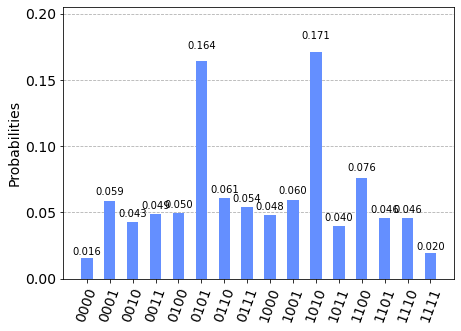

In [14]:
qc = qaoa_circuit(qubo, [res.x[0]], [res.x[1]])

backend = Aer.get_backend('qasm_simulator') # generate the backend simulator
backend.shots = 1024                       # fix the number of shots (runs) of the simulator
    
counts = execute(qc, backend=backend).result().get_counts(qc) # excecute the simulation of the qaoa algorithm
plot_histogram(counts)

In [4]:
Image(url="Images/optimizers.jpg")

There are many possible optimizations to QAOA - some which have only been recently introduced.

One idea is to choose the starting point in a smart way by precomputing the rotation angles.
Another improvement possibility is to only consider a fraction with the highest probabilities during measurement when computing the energy of samples.
An extreme solution would be just to pick up the bitstring with the highest probability and calculate the energy for it. Another idea is so-called warm starting. It essentially means instead of starting with the ground state which is the equal superposition of all states, to pick a state which is closer to the solution. And of course, adjust the mixer Hamiltonian. Now the limiting factor is the device connectivity. When performing the controlled gates between two qubits, which are not directly connected on the actual hardware, the transpiler introduces SWAP-gates which are very costly in terms of runtime. This of course decreases the performance.
